In [7]:
import sys
sys.path.insert(0,'/home/zahradnik/PycharmProjects/master_thesis')

In [29]:
from src.modules import conf, fit, evl, preprocess
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, timedelta
from xgboost import XGBRegressor, XGBRFRegressor
warnings.simplefilter("ignore")
from feature_engine.creation import MathFeatures

In [9]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [24, 8]
plt.rcParams['figure.dpi']

100.0

In [11]:
athlete_name = "zahradnik"
activity_type = "running"

In [12]:
data = fit.load_pcls(
        athlete_name,
        activity_type,
        conf["Paths"]["pcl"],
    )

100%|██████████| 386/386 [00:00<00:00, 705.84it/s]


In [13]:
low_dist, high_dist = preprocess.segment_data(data)
len(low_dist),len(high_dist)

(144, 242)

In [14]:
test_df = preprocess.load_test_activity(path="tracks/bechovice.gpx",
                                        race_day ='2023-10-21-11-30')
print(len(test_df))

2122


In [15]:
if max(test_df.distance) > 10000:
    train_df = fit.clean_data(pd.concat(high_dist))
else:
    train_df = fit.clean_data(pd.concat(low_dist))
len(train_df)

681291

# Cadence

In [16]:
clf = XGBRegressor()

In [17]:
clf.fit(train_df[test_df.columns], train_df.cadence)
test_df['cadence'] = clf.predict(test_df)
test_df['cadence'].mean()

92.23834

In [18]:
test_df= preprocess.calc_windows(df=test_df,
          lagged=15,
          cols=["cadence"])
test_df = preprocess.calc_moving(df=test_df, max_range=110, col="cadence")

# Heart Rate

In [19]:
clf.fit(train_df[test_df.columns], train_df.heart_rate)
test_df["heart_rate"] = clf.predict(test_df)
test_df["heart_rate"].mean()

177.81383

In [20]:
for fce in ["sum", "mean", "min", "max"]:
    test_df = MathFeatures(variables=["heart_rate", "cadence"], func=fce).fit(test_df).transform(test_df)

In [21]:
test_df= preprocess.calc_windows(df=test_df,
          lagged=12,
          cols=["heart_rate"])
test_df = preprocess.calc_moving(df=test_df, max_range=110, col="heart_rate")

In [22]:
clf.fit(train_df[test_df.columns], train_df.enhanced_speed)
test_df["enhanced_speed"] = clf.predict(test_df)

In [23]:
percent_delay = int(len(test_df) * 0.02)  ## 2% delay

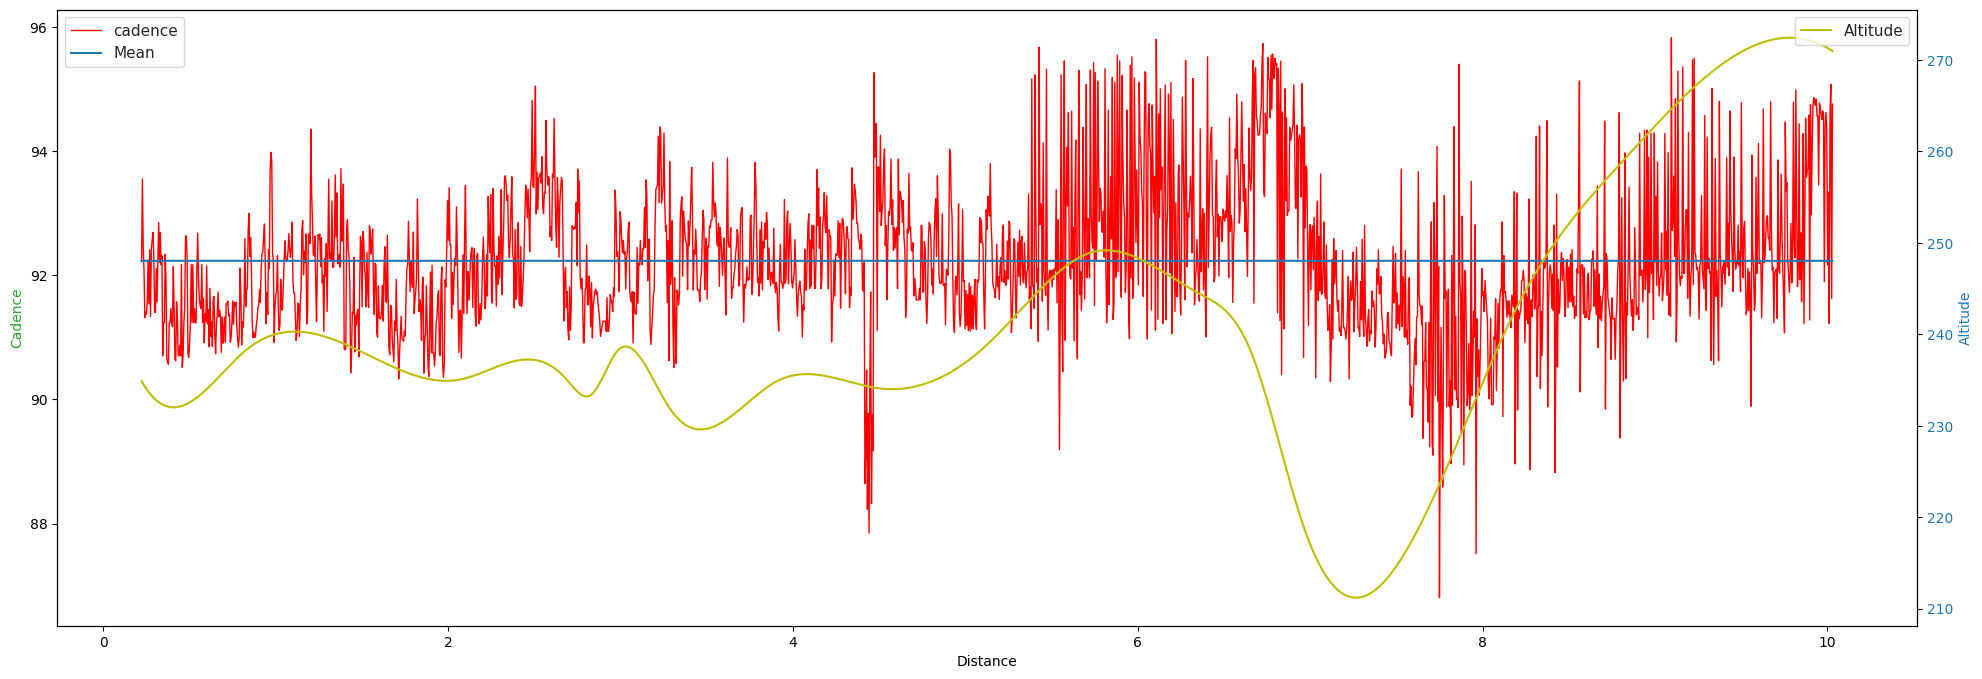

In [24]:
cad_plot = evl.plot(df=test_df[percent_delay:], pred=test_df['cadence'][percent_delay:],endog = "cadence", ylabel="Cadence", color="green")

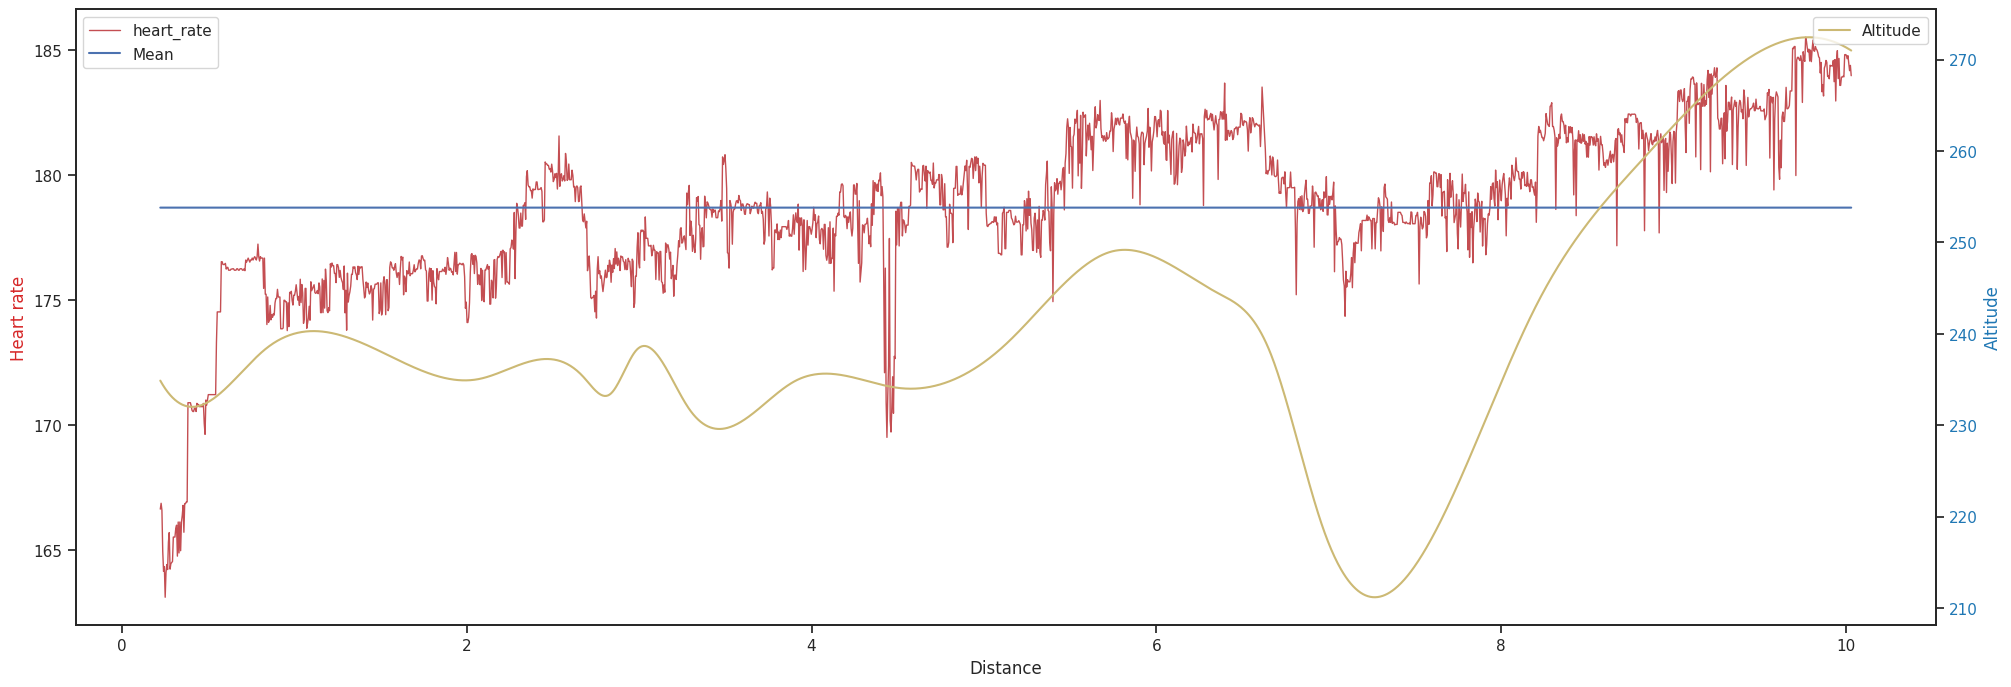

In [25]:
hr_plot = evl.plot(df=test_df[percent_delay:],pred=test_df['heart_rate'][percent_delay:],endog = "heart_rate",ylabel="Heart rate", color="red")

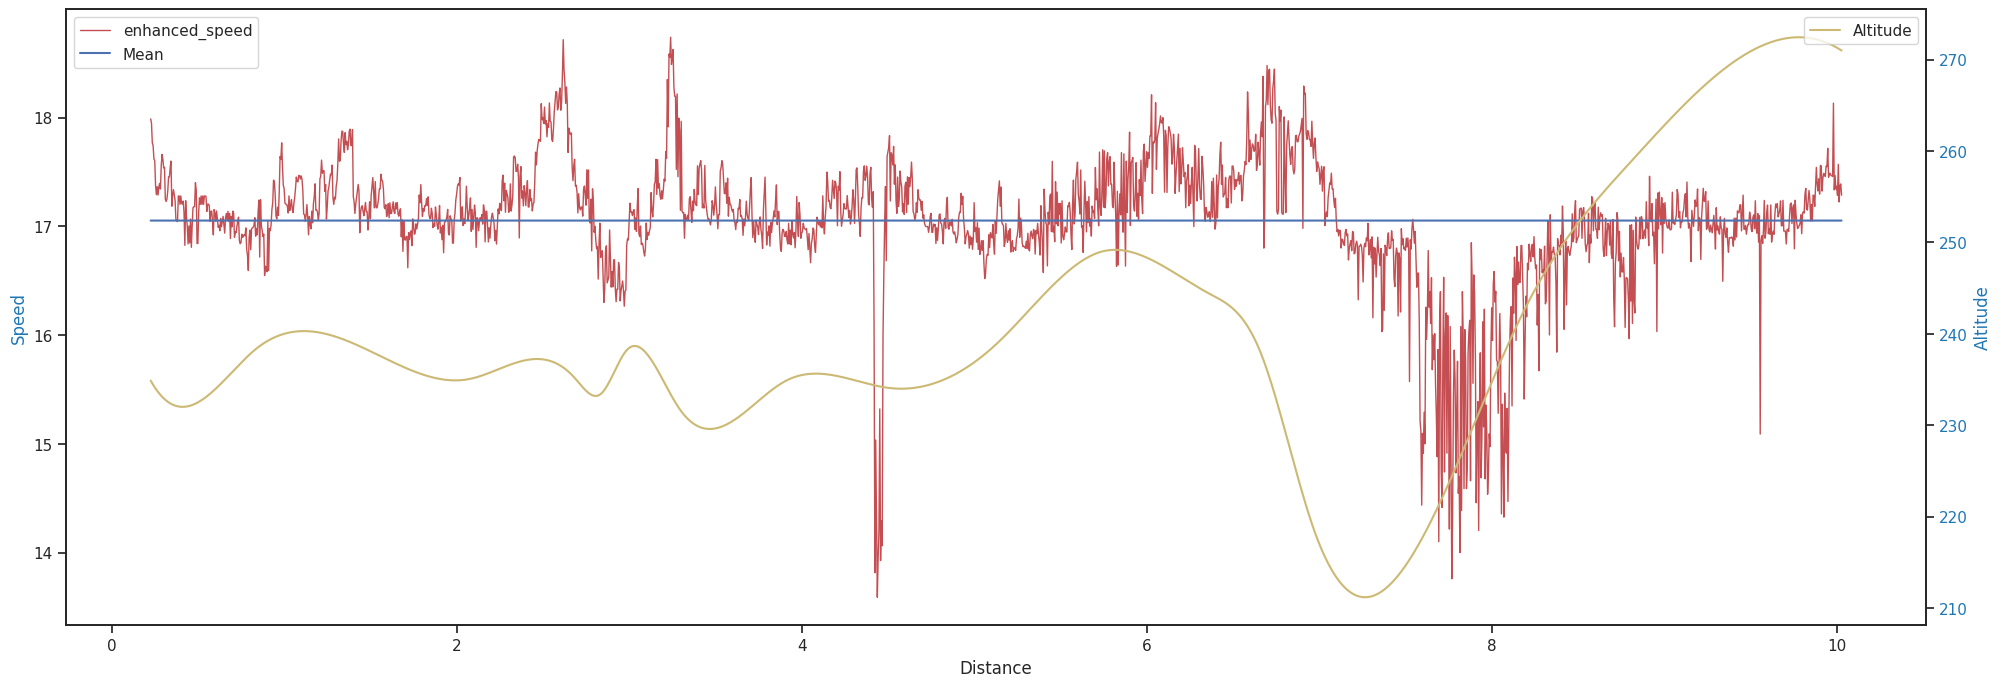

In [26]:
speed_plot = evl.plot(df=test_df[percent_delay:],pred=test_df["enhanced_speed"][percent_delay:],endog = "enhanced_speed",ylabel="Speed", color="blue")

In [27]:
np.mean(test_df.cadence), np.mean(test_df.heart_rate),np.mean(test_df["enhanced_speed"])

(92.23834, 177.81383, 17.04525)

In [28]:
final_time = fit.calc_final_time(max(test_df.distance), test_df.enhanced_speed)
final_time

'Final time: 35:18'

In [32]:
race_day = (datetime.now() + timedelta(days=2)).strftime('%Y-%m-%d-11-30')
race_day

'2023-11-13-11-30'

In [33]:
hradec = preprocess.load_test_activity(path="tracks/hradec_half.gpx",
                                        race_day =race_day)
fit.get_final_df(train_df=train_df,
                 test_df=hradec,
                 model=XGBRegressor())

'75:54'

In [34]:
silvestrak = preprocess.load_test_activity(path="tracks/silvestrak.gpx",
                                        race_day =race_day)
fit.get_final_df(train_df=train_df,
                 test_df=silvestrak,
                 model=XGBRegressor())

'18:24'

In [35]:
boston = preprocess.load_test_activity(path="tracks/boston.gpx",
                                        race_day =race_day)
fit.get_final_df(train_df=train_df,
                 test_df=boston,
                 model=XGBRegressor())

'167:39'

In [ ]:
from src.modules import ui_output

ui_output.save_report(athlete_name=conf["Athlete"]["name"],
                      activity_name="bechovice.gpx"
                      .replace(".gpx", "")
                      .capitalize(),
                      cad_plot=cad_plot,
                      hr_plot=hr_plot,
                      speed_plot=speed_plot,
                      final_time=final_time,
                      df=test_df)